### Molecular graph featurization

Each molecule is represented as a graph with **atoms as nodes** and **bonds as edges**.  
The features are derived using RDKit and stored in the PyTorch Geometric `Data` object.

#### Atom features (12 total)
1. **Atomic number (Z)** – unique element identifier (e.g., 6=C, 8=O, 17=Cl).  
2. **Total degree** – number of directly bonded neighbors (ignores hydrogens if implicit).  
3. **Formal charge** – integer charge assigned to the atom.  
4. **Chirality tag** – stereochemistry (R/S, tetrahedral, etc., as encoded by RDKit).  
5. **Total number of hydrogens** – explicit and implicit hydrogens.  
6. **Aromaticity flag** – 1 if the atom is aromatic, 0 otherwise.  
7. **Ring membership flag** – 1 if the atom is part of any ring, 0 otherwise.  
8. **Explicit valence** – number of explicit bonds (not counting implicit Hs).  
9–12. **Hybridization state (one-hot)**  
   - sp  
   - sp²  
   - sp³  
   - sp³d  

#### Bond features (6 total)
1. **Single bond** – 1 if the bond is a single bond.  
2. **Double bond** – 1 if double bond.  
3. **Triple bond** – 1 if triple bond.  
4. **Aromatic bond** – 1 if aromatic.  
5. **Conjugation** – 1 if the bond is conjugated.  
6. **Ring membership** – 1 if the bond is part of a ring.  

---

In total:
- **12 atom features per atom**
- **6 bond features per bond**


In [53]:
import sys, os
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from llm_mol_interp.utils.dataset import Tox21Dataset
import random
from rdkit.Chem import Draw
from rdkit import Chem


In [9]:
csv_path = "../data/tox21_multitask.csv"   # adjust if needed
smiles_col = "smiles"
task_cols = [
    "NR-AR","NR-AR-LBD","NR-AhR","NR-Aromatase",
    "NR-ER","NR-ER-LBD","NR-PPAR-gamma",
    "SR-ARE","SR-ATAD5","SR-HSE","SR-MMP","SR-p53"
]

dataset = Tox21Dataset(csv_path, smiles_col, task_cols)
print("Number of molecules:", len(dataset))
print("Number of tasks:", dataset.num_tasks)

[13:54:02] WARNING: not removing hydrogen atom without neighbors
[13:54:02] WARNING: not removing hydrogen atom without neighbors


Number of molecules: 7831
Number of tasks: 12


SMILES: BrCCc1ccccc1
Labels: tensor([[ 0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.]])


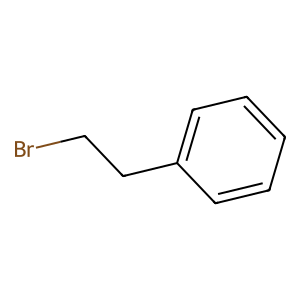

In [43]:

idx = 15
smiles = dataset.smiles[idx]
mol = Chem.MolFromSmiles(smiles)

print("SMILES:", smiles)
print("Labels:", dataset.get(idx).y)

Draw.MolToImage(mol)


In [44]:

img = Draw.MolToImage(mol, size=(300,300))  # returns a PIL.Image object
img.save("smiles_example.png")  # save to file

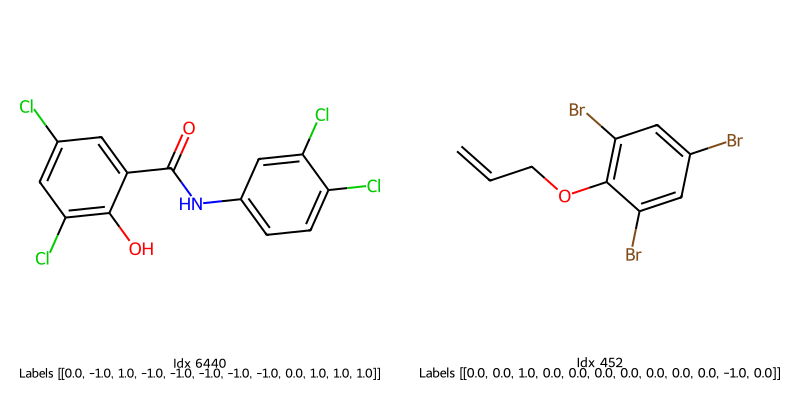

In [18]:
indices = random.sample(range(len(dataset)), 2)

mols = [Chem.MolFromSmiles(dataset.smiles[i]) for i in indices]
legends = [f"Idx {i}\nLabels {dataset.get(i).y.tolist()}" for i in indices]

img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400,400), legends=legends)
img


In [19]:
sample = dataset.get(0)
print("Node feature matrix shape:", sample.x.shape)   # [num_atoms, num_features]
print("First 5 atoms:\n", sample.x[:5])


Node feature matrix shape: torch.Size([4, 12])
First 5 atoms:
 tensor([[35,  1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0],
        [ 6,  4,  0,  0,  1,  0,  0,  3,  0,  0,  1,  0],
        [35,  1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0],
        [35,  1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0]])


In [21]:
dataset.get(1)

Data(x=[7, 12], edge_index=[2, 12], edge_attr=[12, 6], z=[7], node_feats=[7, 11], y=[1, 12], mol_id='1')

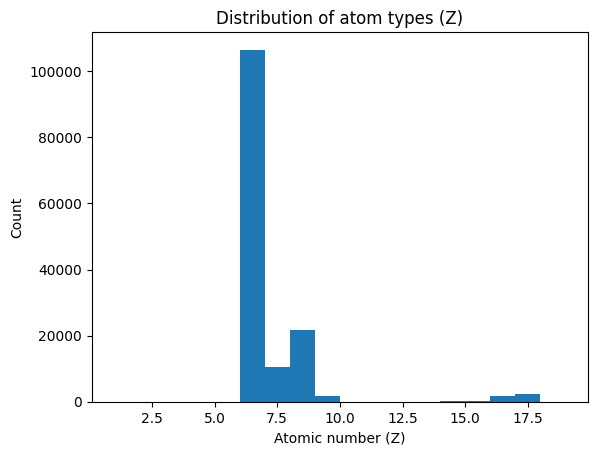

In [22]:
import matplotlib.pyplot as plt

all_atoms = []
for i in range(len(dataset)):
    all_atoms.extend(dataset.get(i).z.tolist())

plt.hist(all_atoms, bins=range(1, 20))  # limit to light elements
plt.xlabel("Atomic number (Z)")
plt.ylabel("Count")
plt.title("Distribution of atom types (Z)")
plt.show()


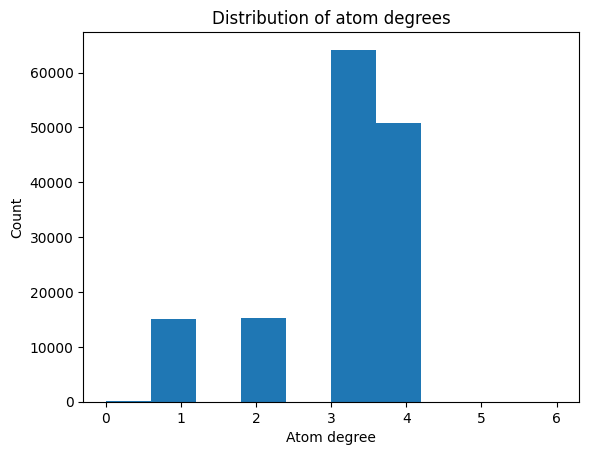

Aromatic atoms: 48716 / 145459


In [23]:
all_degrees, all_aromatic = [], []

for i in range(len(dataset)):
    feats = dataset.get(i).node_feats
    all_degrees.extend(feats[:,0].tolist())     # degree is 1st column in node_feats
    all_aromatic.extend(feats[:,4].tolist())    # aromatic flag

plt.hist(all_degrees, bins=10)
plt.xlabel("Atom degree")
plt.ylabel("Count")
plt.title("Distribution of atom degrees")
plt.show()

print("Aromatic atoms:", sum(all_aromatic), "/", len(all_aromatic))


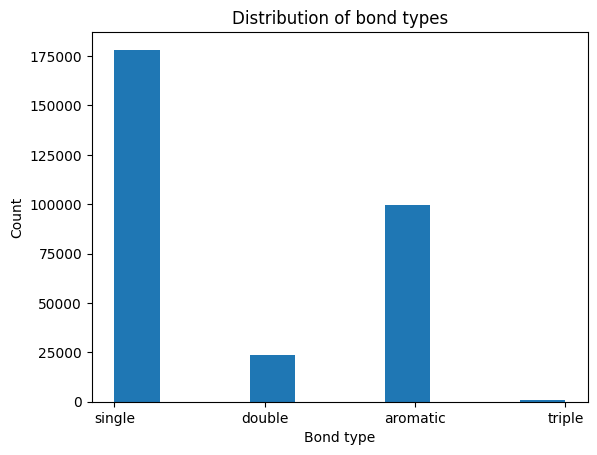

In [24]:
all_bonds = []
for i in range(len(dataset)):
    edge_attr = dataset.get(i).edge_attr
    for row in edge_attr:
        if row[0] == 1: all_bonds.append("single")
        elif row[1] == 1: all_bonds.append("double")
        elif row[2] == 1: all_bonds.append("triple")
        elif row[3] == 1: all_bonds.append("aromatic")

plt.hist(all_bonds)
plt.xlabel("Bond type")
plt.ylabel("Count")
plt.title("Distribution of bond types")
plt.show()


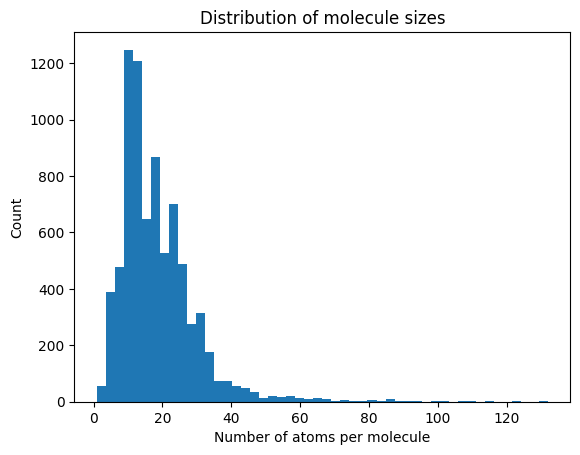

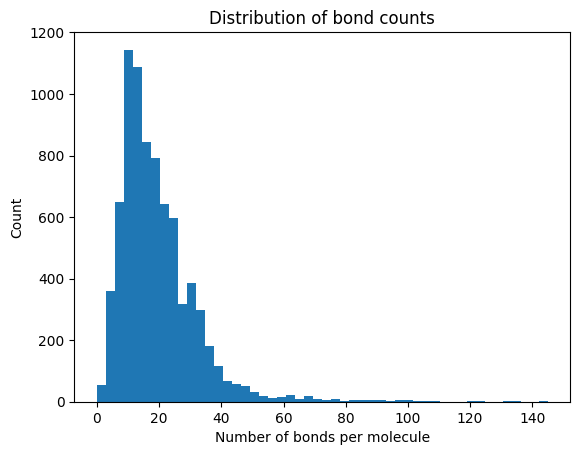

In [25]:
num_atoms = [dataset.get(i).x.shape[0] for i in range(len(dataset))]
num_bonds = [dataset.get(i).edge_index.shape[1]//2 for i in range(len(dataset))]

plt.hist(num_atoms, bins=50)
plt.xlabel("Number of atoms per molecule")
plt.ylabel("Count")
plt.title("Distribution of molecule sizes")
plt.show()

plt.hist(num_bonds, bins=50)
plt.xlabel("Number of bonds per molecule")
plt.ylabel("Count")
plt.title("Distribution of bond counts")
plt.show()


/Users/marci/.pyenv/versions/3.10.13/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


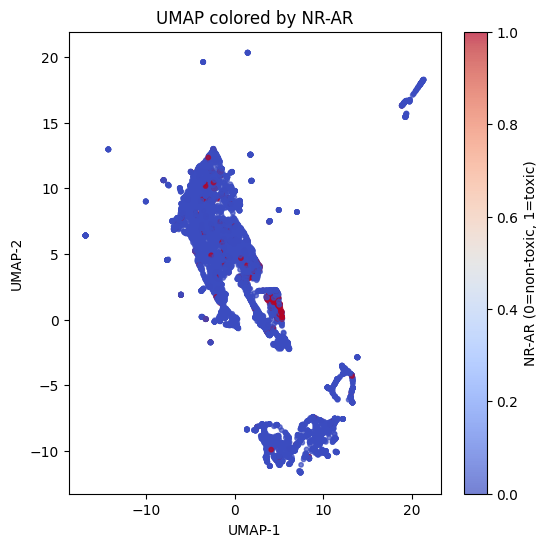

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import umap

mol_feats = []
for i in range(len(dataset)):
    data = dataset.get(i)
    mol_feats.append(data.node_feats.float().mean(dim=0).numpy())
mol_feats = np.vstack(mol_feats)
mol_labels = np.vstack([dataset.get(i).y.squeeze(0).numpy() for i in range(len(dataset))])
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
proj = umap_model.fit_transform(mol_feats)

# Pick a task to visualize
task_idx = 0  # 0=NR-AR
task_name = task_cols[task_idx]

labels = mol_labels[:, task_idx]
mask = labels != -1  # exclude missing
X = proj[mask]
y = labels[mask]

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=10, alpha=0.7)
plt.colorbar(label=f"{task_name} (0=non-toxic, 1=toxic)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title(f"UMAP colored by {task_name}")
plt.show()

In [48]:
sample = dataset.get(0)

print("Molecule ID:", sample.mol_id)
print("Labels:", sample.y)
print("\nAtomic numbers (z):")
print(sample.z)
print("\nAtom features (excluding Z):")
print(sample.node_feats)
print("\nBond features (edge_attr):")
print(sample.edge_attr)


Molecule ID: 0
Labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Atomic numbers (z):
tensor([35,  6, 35, 35])

Atom features (excluding Z):
tensor([[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [4, 0, 0, 1, 0, 0, 3, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]])

Bond features (edge_attr):
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])


### Example: Atom features for the first compound (`BrC(Br)Br`)

| Atom | Z  | Degree | Charge | Chirality | H count | Aromatic | Ring | Valence | sp | sp² | sp³ | sp³d |
| ---- | -- | ------ | ------ | --------- | ------- | -------- | ---- | ------- | -- | --- | --- | ---- |
| Br   | 35 | 1      | 0      | 0         | 0       | 0        | 0    | 1       | 0  | 0   | 0   | 0    |
| C    | 6  | 4      | 0      | 0         | 0       | 0        | 0    | 3       | 0  | 0   | 0   | 1    |
| Br   | 35 | 1      | 0      | 0         | 0       | 0        | 0    | 1       | 0  | 0   | 0   | 0    |
| Br   | 35 | 1      | 0      | 0         | 0       | 0        | 0    | 1       | 0  | 0   | 0   | 0    |


In [50]:
sample = dataset.get(23)

print("Molecule ID:", sample.mol_id)
print("Labels:", sample.y)
print("\nAtomic numbers (z):")
print(sample.z)
print("\nAtom features (excluding Z):")
print(sample.node_feats)
print("\nBond features (edge_attr):")
print(sample.edge_attr)

Molecule ID: 23
Labels: tensor([[ 0., -1.,  0., -1.,  1., -1.,  1., -1.,  0., -1., -1.,  1.]])

Atomic numbers (z):
tensor([35,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

Atom features (excluding Z):
tensor([[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [3, 0, 0, 0, 1, 1, 4, 0, 1, 0, 0],
        [3, 0, 0, 0, 1, 1, 4, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 0, 1, 1, 4, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 0, 1, 1, 4, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0],
        [3, 0, 0, 0, 1, 1, 4, 0, 1, 0, 0]])

Bond features (edge_attr):
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1.],
        [

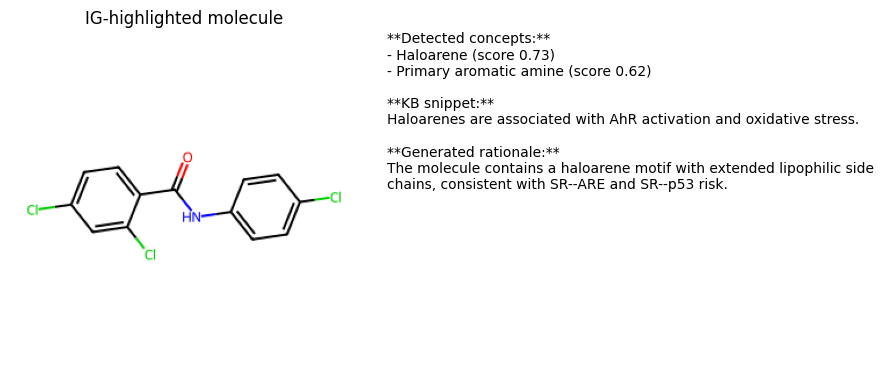

In [56]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
smiles = "O=C(Nc1ccc(Cl)cc1)c2ccc(Cl)cc2Cl"
mol = Chem.MolFromSmiles(smiles)
img = Draw.MolToImage(mol, size=(300,300))

# --- (ii–iv) Mock metadata for the explanations.jsonl ---
concepts = [("Haloarene", 0.73), ("Primary aromatic amine", 0.62)]
kb_snippet = "Haloarenes are associated with AhR activation and oxidative stress."
rationale = "The molecule contains a haloarene motif with extended lipophilic side chains, consistent with SR--ARE and SR--p53 risk."
fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("IG-highlighted molecule")
ax[1].axis("off")
text = "**Detected concepts:**\n" + \
       "\n".join([f"- {c} (score {s:.2f})" for c,s in concepts]) + "\n\n" + \
       f"**KB snippet:**\n{kb_snippet}\n\n" + \
       f"**Generated rationale:**\n{rationale}"
ax[1].text(0, 1, text, va="top", fontsize=10, wrap=True)

plt.tight_layout()
plt.savefig("qual_panel_example.pdf")
plt.show()


In [59]:

# --- Configuration ---
FAITHFULNESS_JSON = "./data/faithfulness_NR-AR.json"   # update as needed
SUMMARY_JSON = "faithfulness_NR-AR_summary.json"  # set to None if not available
OUT_DIR = "Images"
IS_JSONL = False
ALPHA = 0.05  # 95%

import os, json, math, gzip
from typing import List, Dict, Any, Iterable, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs(OUT_DIR, exist_ok=True)
print("Output directory:", os.path.abspath(OUT_DIR))


Output directory: /Users/marci/Desktop/ORGANIZED_CODE/notebooks/Images


In [60]:

def open_maybe_gzip(path: str):
    return gzip.open(path, "rt") if path.endswith(".gz") else open(path, "r")

def load_records(path: str, is_jsonl: bool):
    if is_jsonl:
        recs = []
        with open_maybe_gzip(path) as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                recs.append(json.loads(line))
        return recs
    else:
        with open_maybe_gzip(path) as f:
            data = json.load(f)
            if isinstance(data, dict) and "records" in data:
                return data["records"]
            return data if isinstance(data, list) else []

recs = load_records(FAITHFULNESS_JSON, IS_JSONL)
print(f"Loaded {len(recs)} records from {FAITHFULNESS_JSON}")
if not recs:
    raise SystemExit("No records loaded. Check FAITHFULNESS_JSON / IS_JSONL.")


Loaded 708 records from ./data/faithfulness_NR-AR.json


In [61]:

import numpy as np
import pandas as pd

df = pd.DataFrame.from_records(recs)
expected_cols = ["endpoint", "deletion_auc", "insertion_auc", "comprehensiveness", "sufficiency"]
for c in expected_cols:
    if c not in df.columns:
        df[c] = np.nan
for c in ["deletion_auc", "insertion_auc", "comprehensiveness", "sufficiency"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
if "endpoint" not in df.columns or df["endpoint"].isna().all():
    df["endpoint"] = "UNKNOWN"
print(df[expected_cols].head())
print("Endpoints in file:", sorted(df["endpoint"].unique()))


  endpoint  deletion_auc  insertion_auc  comprehensiveness  sufficiency
0    NR-AR      0.141035       0.280637           0.166757     0.313245
1    NR-AR      0.118034       0.192499           0.024935     0.248396
2    NR-AR      0.272210       0.335354           0.093642     0.390786
3    NR-AR      0.232990       0.322864           0.049659     0.359737
4    NR-AR      0.201463       0.298075           0.030178     0.338392
Endpoints in file: ['NR-AR']


In [62]:

import math
def mean_std_ci(x, alpha: float = 0.05):
    x = x.astype(float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, (np.nan, np.nan)
    m = float(np.mean(x))
    s = float(np.std(x, ddof=1)) if n > 1 else 0.0
    z = 1.96  # 95% approx
    se = s / math.sqrt(n) if n > 1 else 0.0
    lo, hi = m - z*se, m + z*se
    return m, s, (lo, hi)

def summarize_group(g, alpha: float = 0.05):
    out = {}
    for metric in ["deletion_auc", "insertion_auc", "comprehensiveness", "sufficiency"]:
        m, s, (lo, hi) = mean_std_ci(g[metric], alpha)
        out[f"{metric}_mean"] = m
        out[f"{metric}_std"] = s
        out[f"{metric}_ci_lo"] = lo
        out[f"{metric}_ci_hi"] = hi
        out[f"{metric}_n"] = g[metric].notna().sum()
    out["n_records"] = len(g)
    return pd.Series(out)

by_ep = df.groupby("endpoint", dropna=False).apply(lambda g: summarize_group(g, ALPHA)).reset_index()
by_ep.rename(columns={"endpoint":"Assay"}, inplace=True)
overall = summarize_group(df, ALPHA).to_frame().T
overall.insert(0, "Assay", "All (pooled)")

by_ep_csv = os.path.join(OUT_DIR, "faithfulness_by_assay.csv")
overall_csv = os.path.join(OUT_DIR, "faithfulness_overall.csv")
by_ep.to_csv(by_ep_csv, index=False)
overall.to_csv(overall_csv, index=False)
(by_ep.head(), overall)


/var/folders/3b/1dzvglj17w110wnj0rq1ngkh0000gn/T/ipykernel_86944/1112264645.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_ep = df.groupby("endpoint", dropna=False).apply(lambda g: summarize_group(g, ALPHA)).reset_index()


(   Assay  deletion_auc_mean  deletion_auc_std  deletion_auc_ci_lo  \
 0  NR-AR           0.205986          0.070568            0.200788   
 
    deletion_auc_ci_hi  deletion_auc_n  insertion_auc_mean  insertion_auc_std  \
 0            0.211184           708.0            0.319092           0.063258   
 
    insertion_auc_ci_lo  insertion_auc_ci_hi  ...  comprehensiveness_std  \
 0             0.314432             0.323752  ...               0.157006   
 
    comprehensiveness_ci_lo  comprehensiveness_ci_hi  comprehensiveness_n  \
 0                 0.137715                 0.160846                708.0   
 
    sufficiency_mean  sufficiency_std  sufficiency_ci_lo  sufficiency_ci_hi  \
 0          0.320386         0.063132           0.315736           0.325036   
 
    sufficiency_n  n_records  
 0          708.0      708.0  
 
 [1 rows x 22 columns],
           Assay  deletion_auc_mean  deletion_auc_std  deletion_auc_ci_lo  \
 0  All (pooled)           0.205986          0.070568      

Saved: Images/hist_deletion_auc.pdf
Saved: Images/hist_insertion_auc.pdf
Saved: Images/hist_comprehensiveness.pdf
Saved: Images/hist_sufficiency.pdf


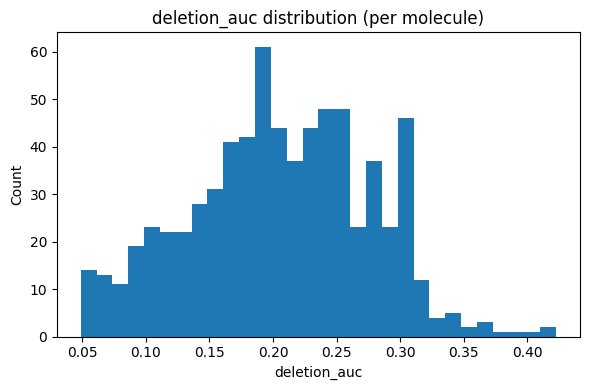

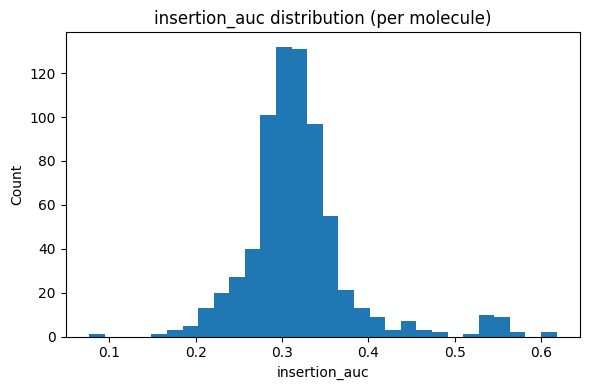

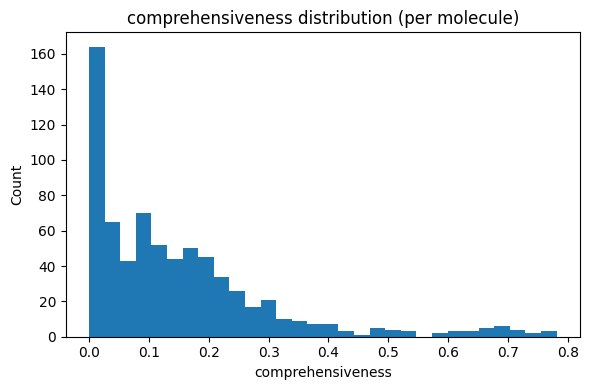

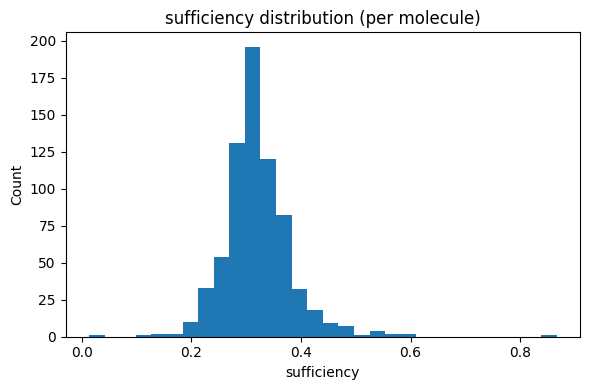

In [65]:

for metric in ["deletion_auc", "insertion_auc", "comprehensiveness", "sufficiency"]:
    fig, ax = plt.subplots(figsize=(6,4))
    vals = df[metric].dropna().values
    if len(vals) == 0:
        print("No values for", metric)
        continue
    ax.hist(vals, bins=30)
    ax.set_title(f"{metric} distribution (per molecule)")
    ax.set_xlabel(metric)
    ax.set_ylabel("Count")
    fig.tight_layout()
    out_pdf = os.path.join(OUT_DIR, f"hist_{metric}.pdf")
    fig.savefig(out_pdf, bbox_inches="tight")
    print("Saved:", out_pdf)
